In [1]:
from pyspark import SparkContext,SparkConf
from operator import add
from pyspark.sql import SparkSession,Row
from pandas import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
import re
conf = SparkConf().setAppName("userCF").setMaster("local[4]")
spark = SparkSession.builder\
    .config(conf=conf) \
    .enableHiveSupport()\
    .getOrCreate()
sc=spark.sparkContext

In [1]:
!! hadoop fs -ls /user/root/data/amazon


['Found 14 items',
 'drwxr-xr-x   - root supergroup           0 2017-11-13 19:43 /user/root/data/amazon/choosed_parquet',
 '-rw-r--r--   2 root supergroup 94247104734 2017-10-28 00:54 /user/root/data/amazon/complete.json',
 'drwxr-xr-x   - root supergroup           0 2017-10-31 04:33 /user/root/data/amazon/complete_csv',
 'drwxr-xr-x   - root supergroup           0 2017-10-31 23:42 /user/root/data/amazon/complete_sample',
 '-rw-r--r--   1 root supergroup  3366981927 2017-10-27 07:29 /user/root/data/amazon/item_dedup.csv',
 'drwxr-xr-x   - root supergroup           0 2017-11-07 23:09 /user/root/data/amazon/rating_parquet',
 'drwxr-xr-x   - root supergroup           0 2017-11-06 09:10 /user/root/data/amazon/result',
 'drwxr-xr-x   - root supergroup           0 2017-10-31 04:16 /user/root/data/amazon/review_Books',
 'drwxr-xr-x   - root supergroup           0 2017-11-02 09:16 /user/root/data/amazon/review_csv',
 'drwxr-xr-x   - root supergroup           0 2017-11-12 22:06 /user/root/data/

In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#__author__:yanbin
from pyspark import SparkContext,SparkConf
from operator import add,itemgetter
from pyspark.sql import SparkSession,Row
from pandas import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
import time
import math
class ItemCF_spark(object):  
    def __init__(self,df,item_pair_sim=None,spark=None,topN=10,NN=100):
        self.spark = spark
        if (self.spark is None):
            conf = SparkConf().setAppName("itemCF").setMaster("yarn")
            self.spark = SparkSession.builder\
                .config(conf=conf) \
                .enableHiveSupport()\
                .getOrCreate()
        sc = spark.sparkContext 
        self.df = df
        self.item_pair_sim = item_pair_sim
        self.topN = topN
        self.NN = NN

    def itemSimilarity(self):
        # RDD[(uid,(aid,score))] 
        user_item_score = self.df.rdd.map(lambda x:(x[0],[x[1],x[2]]))
        item_score_pair = user_item_score.join(user_item_score)\
                        .map(lambda x:((x[1][0][0],x[1][1][0]),(x[1][0][1],x[1][1][1])))
        item_pair_ALL = item_score_pair.map(lambda f:(f[0], f[1][0] * f[1][1])).reduceByKey(add,300)
        item_pair_XX_YY = item_pair_ALL.filter(lambda f:f[0][0] == f[0][1])
        item_pair_XY = item_pair_ALL.filter(lambda f:f[0][0] != f[0][1])
        #RDD[(aid1,score11 * score11 + score21 * score21)] 
        item_XX_YY = item_pair_XX_YY.map(lambda f:(f[0][0], f[1]))
        #RDD(aid1,((aid1,aid2,XY),XX))
        item_XY_XX = item_pair_XY.map(lambda f:(f[0][0], (f[0][0], f[0][1], f[1]))).join(item_XX_YY) 
        #RDD[(aid2,((aid1,aid2,
        #           score11 * score12 + score21 * score22,score11 * score11 + score21 * score21),
        #           score12 * score12 + score22 * score22))] 
        item_XY_XX_YY = item_XY_XX.map(lambda f:(f[1][0][1],(f[1][0][0],f[1][0][1],f[1][0][2],f[1][1]))).join(item_XX_YY)  
        # item_XY_XX_YY中的(aid1,aid2,XY,XX,YY)) 
        # RDD[(aid1,aid2,
        # score11 * score12 + score21 * score22,score11 * score11 + score21 * score21,score12 * score12 + score22 * score22)]       
        item_pair_XY_XX_YY = item_XY_XX_YY.map(lambda f:(f[1][0][0], f[1][0][1], f[1][0][2], f[1][0][3], f[1][1]))  
        # item_pair_XY_XX_YY为(aid1,aid2,XY / math.sqrt(XX * YY)) 
        # RDD[(aid1,aid2,
        # score11 * score12 + score21 * score22 / math.sqrt((score11 * score11 + score21 * score21)*(score12 * score12 + score22 * score22))] 
        item_pair_sim = item_pair_XY_XX_YY.map(lambda f :(f[0], (f[1], f[2] / math.sqrt(f[3] * f[4]))))  
        return item_pair_sim
    

    def train(self):
        item_pair_sim = self.itemSimilarity()
        item_pair_sim.cache()  
        self.item_pair_sim=item_pair_sim
    



def recommend(df,item_pair_sim,NN=100,topN =10,Normalization=False):
    def itemNN(item_pair_sim,NN=100,Normalization=False):
        item_sim = item_pair_sim.filter(lambda f:f[1][1]>0.05)\
                            .groupByKey()\
                            .mapValues(list)
        if Normalization:
            def norm(x):
                m =  __builtin__.max([i[1] for i in x])
                l = []
                for i in x:
                    l.append((i[0],i[1]/m))
                return l
            item_sim = item_sim.mapValues(lambda x:norm(x))
        item_simNN = item_sim.mapValues(lambda x:sorted(x,key=itemgetter(1),reverse=True)[:NN])\
                            .collectAsMap()
        return item_simNN
    
    def getOrElse(f,item_sim_bd):
        items_sim = item_sim_bd.value.get(f[0][1]) 
        if items_sim is None:
            items_sim = [("0", 0.0)]
        for w in items_sim:
            yield ((f[0][0],w[0]),w[1]*f[1])
            
    user_item_score = df.rdd.map(lambda x:((x[0],x[1]),x[2]))
    item_sim_bd = sc.broadcast(itemNN(item_pair_sim,NN=NN,Normalization=Normalization))
#     /* 
#      * 提取item_sim_user_score为((user,item2),sim * score) 
#      * RDD[(user,item2),sim * score] 
#      */  

    user_item_simscore = user_item_score.flatMap(lambda f:getOrElse(f,item_sim_bd))\
                                        .filter(lambda f:f[1]> 0.03)  
#       /*
#      * 聚合user_item_simscore为 (user,（item2,sim1 * score1 + sim2 * score2）)
#      * 假设user观看过两个item,评分分别为score1和score2，item2是与user观看过的两个item相似的item,相似度分别为sim1，sim2 
#      * RDD[(user,item2),sim1 * score1 + sim2 * score2）)] 
#      */  
    user_item_rank = user_item_simscore.reduceByKey(add,1000)  

#     /* 
#      * 过滤用户已看过的item,并对user_item_rank基于user聚合 
#      * RDD[(user,CompactBuffer((item2,rank2）,(item3,rank3)...))] 
#      */  
    user_items_ranks = user_item_rank.subtractByKey(user_item_score)\
                                     .map(lambda f:(f[0][0], (f[0][1], f[1])))\
                                     .groupByKey()  
#     /* 
#      * 对user_items_ranks基于rank降序排序，并提取topN,其中包括用户已观看过的item 
#      * RDD[(user,ArrayBuffer((item2,rank2）,...,(itemN,rankN)))] 
#      */  
    user_items_ranks_desc = user_items_ranks.mapValues(list)\
                            .mapValues(lambda x:sorted(x,key=itemgetter(1),reverse=True)[:topN])
    return user_items_ranks_desc

from Evaluator import Evaluator
def evaluate(evaluator):
    precise = evaluator.precision()
    coverage = evaluator.coverage()
    popularity = evaluator.popularity()
    recall = evaluator.recall()
    return precise,recall,coverage,popularity

if __name__ == "__main__": 
    import os
    PYSPARK_PYTHON = "/usr/bin/python2.7"
    os.environ["PYSPARK_PYTHON"] = PYSPARK_PYTHON
    conf = SparkConf().setAppName("itemCF").setMaster("yarn")
    conf.set('spark.executor.cores','30')
    conf.set('spark.executor.memory','90g')
    conf.set('spark.executor.instances','8')
    conf.set('spark.sql.shuffle.partitions','400')
    conf.set('spark.default.parallelism','200')
    conf.set('spark.scheduler.mode','fair')
#     conf.set("spark.shuffle.file.buffer","128k").set("spark.reducer.maxSizeInFlight","96M")
    spark = SparkSession.builder\
        .config(conf=conf) \
        .getOrCreate()
    sc=spark.sparkContext 
    start = time.time()
    inputPath = "data/ml_latest_small/ratings.csv"
    schema = StructType([
            StructField("user", StringType(), True),
            StructField("item", StringType(), True),
            StructField("rating", DoubleType(), True),
            StructField("timestamp", LongType(), True)])
#     inputPath = "data/amazon/complete_csv"
#     schema = StructType([
#         StructField("user", StringType(), True),
#         StructField("item", StringType(), True),
#         StructField("rating", DoubleType(), True),
#         StructField("text", StringType(), True),
#         StructField("summary", StringType(), True)])
    ratingDf = spark.read.csv(inputPath,header=True,schema=schema,nullValue='Nan')
#     inputPath = "data/amazon/rating_parquet"
#     inputPath = "data/amazon/choosed_parquet"
#     ratingDf = spark.read.parquet(inputPath)
#     ratingDf,_ = ratingDf.randomSplit([1.0,9.0],seed=40)
    ratingDf = ratingDf.repartition(300)
#     ratingDf = ratingDf.select('user','item','rating')
#     user_count = ratingDf.groupBy('user').agg(count('*').alias('user_count')).filter('user_count>100')
#     item_count = ratingDf.groupBy('item').agg(count('*').alias('item_count')).filter('item_count>100')
#     ratingDf = ratingDf.join(user_count,on='user',how='inner')
#     ratingDf = ratingDf.join(item_count,on='item',how='inner')
    ratingDf.printSchema()
    ratingDf.show(5)
    n = ratingDf.count()
#     ratingDf = ratingDf.withColumn('score',col('rating')*0+1).select('user','item','score')    
    print 'total lines: %s' %n
    train,test = ratingDf.randomSplit([4.0,1.0],seed=40)
    train.cache()
    test.cache()
    itemCF = ItemCF_spark(df=train,spark=spark)
    itemCF.train()
    end = time.time()
    print 'model trainning spend: %s s' %(end-start)
    start = time.time()
    for NN in [5,10,20,40,60,80,100,120]:
        recTopN = recommend(train,itemCF.item_pair_sim,NN=NN,topN=10,Normalization=False)
        pre = spark.createDataFrame(data=recTopN.flatMapValues(lambda x:x).map(lambda x:(x[0],x[1][0],x[1][1])),
                                    schema=['user','item','rating'])
        evaluator = Evaluator(train,test,pre)
        (precise,recall,coverage,popularity) = evaluate(evaluator)
        end = time.time()
        print ('NN:%3d,  precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
                %(NN,precise*100,recall*100,coverage*100,popularity,end-start))
        pre.write.parquet(partitionBy='user',path='data/ml-latest-small/result/itemCF/itcf_'+str(NN),mode='ignore')
        start = time.time()
        

root
 |-- user: string (nullable = true)
 |-- item: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)

+----+----+------+---------+
|user|item|rating|timestamp|
+----+----+------+---------+
|   4|1387|   5.0|949810261|
|   7| 737|   1.0|851866763|
|  12|1220|   5.0|955407153|
|  15| 858|   5.0|997938703|
|  15|2324|   2.0|997939328|
+----+----+------+---------+
only showing top 5 rows

total lines: 100003
model trainning spend: 5.20521092415 s
NN:  5,  precise:22.13%,  recall:7.47%,  coverage:11.36%,  popularity:4.32, time: 176.164921045 s
NN: 10,  precise:22.79%,  recall:7.69%,  coverage:8.83%,  popularity:4.53, time: 27.228924036 s
NN: 20,  precise:23.28%,  recall:7.86%,  coverage:7.02%,  popularity:4.62, time: 27.2996981144 s
NN: 40,  precise:23.82%,  recall:8.04%,  coverage:6.41%,  popularity:4.68, time: 30.7837769985 s
NN: 60,  precise:23.55%,  recall:7.95%,  coverage:6.25%,  popularity:4.67, time: 33.9822731018 s
NN: 80,  precis

In [3]:
sc.stop()
spark.stop()

In [2]:
##### !/usr/bin/env python
#-*- coding:utf-8 -*-
############################
#File Name: recommendator.py
#Author: yanbin
#Mail: yanbin918@gmail.com
import sys
sys.path.append('../')
from ml_latest_small.data import *
from Collaborative_Filter.itemBased import ItemCFModel,ItemCF
from Collaborative_Filter.userBased import UserCFModel,UserCF
from Collaborative_Filter.lfmBased import lfmModel,lfm
from Comparision.randomBased import RandomModel
from Comparision.topnBased import topnModel
import pickle
import multiprocessing
import os
from Evaluation.Evaluator import Evaluator
import time
def load_result(path):
    pkl_file = open(path, 'rb')
    prediction_dict = pickle.load(pkl_file)
    # pprint.pprint(data)
    pkl_file.close()
    return prediction_dict

def evaluate(evaluator):
    precise = evaluator.precision()
    coverage = evaluator.coverage()
    popularity = evaluator.popularity()
#     popularity = 5
    recall = evaluator.recall()
    return precise,recall,coverage,popularity

def itemCF_predict(train_dict,test_dict,ItemCF_model,K):
    #recommendation for every user in train_Dataset
    users = train_dict.keys()
    user_nums = len(users)
    i = 0
    prediction_dict ={}
    for user in users:
        prediction_dict[user]=ItemCF_model.recommendation(user,config={'K':K,'N':10}).keys()
    return prediction_dict

start = time.time()
train_dict = train.rdd.map(lambda x:(x['user'],(x['item'],x['rating'])))\
             .groupByKey().mapValues(dict).collectAsMap()
test_dict = test.rdd.map(lambda x:(x['user'],(x['item'],x['rating'])))\
             .groupByKey().mapValues(dict).collectAsMap()
itemCF_local = ItemCF()
#triain ItemCF_model
print "训练基于物品协同过滤算法模型........"
ItemCF_model=itemCF_local.train(train_dict)
end = time.time()   
print 'model trainning spend: %s s' %(end-start)
start = time.time()   
for K in [5,10,20,40,60,80,100,120]:
    prediction_dict = itemCF_predict(train_dict,test_dict,ItemCF_model,K) 
    evaluator = Evaluator(train_dict,test_dict,prediction_dict,N=10)
    (precise,recall,coverage,popularity) = evaluate(evaluator)
    end = time.time()
    print ('NN:%3d,  precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
            %(K,precise*100,recall*100,coverage*100,popularity,end-start))
    start = time.time()    

训练基于物品协同过滤算法模型........
model trainning spend: 30.4247040749 s
NN:  5,  precise:21.25%,  recall:7.17%,  coverage:11.18%,  popularity:4.32, time: 267.551539898 s
NN: 10,  precise:22.24%,  recall:7.50%,  coverage:8.83%,  popularity:4.50, time: 269.75869298 s
NN: 20,  precise:22.67%,  recall:7.65%,  coverage:7.32%,  popularity:4.60, time: 272.405033112 s
NN: 40,  precise:22.62%,  recall:7.64%,  coverage:6.26%,  popularity:4.66, time: 277.462280989 s
NN: 60,  precise:22.62%,  recall:7.64%,  coverage:5.94%,  popularity:4.66, time: 278.143131018 s
NN: 80,  precise:22.09%,  recall:7.45%,  coverage:5.67%,  popularity:4.66, time: 276.387102127 s
NN:100,  precise:21.95%,  recall:7.41%,  coverage:5.66%,  popularity:4.65, time: 274.983546019 s
NN:120,  precise:21.85%,  recall:7.37%,  coverage:5.65%,  popularity:4.64, time: 275.487257957 s


In [5]:
# ratingDf.select('user','item','rating').write.csv(path='/user/root/data/amazon/rating_csv',mode='overwrite',)
# pre.write.csv(path='data/amazon/result/lfm_csv_'+'_'.join(time.ctime().split()[:3]),mode='overwrite',)
# ratingDf.select('user','item','rating').write.parquet('/user/root/data/amazon/rating_parquet',
#                                                       compression='gzip',
#                                                       mode = 'overwrite')
# !! hadoop fs -rm -r /user/root/data/amazon/rating_parquet
!! hadoop fs -ls -h /user/root/data/amazon/


['Found 13 items',
 '-rw-r--r--   2 root supergroup      87.8 G 2017-10-28 00:54 /user/root/data/amazon/complete.json',
 'drwxr-xr-x   - root supergroup           0 2017-10-31 04:33 /user/root/data/amazon/complete_csv',
 'drwxr-xr-x   - root supergroup           0 2017-10-31 23:42 /user/root/data/amazon/complete_sample',
 '-rw-r--r--   1 root supergroup       3.1 G 2017-10-27 07:29 /user/root/data/amazon/item_dedup.csv',
 '-rw-r--r--   1 root supergroup      54.3 G 2017-10-27 07:34 /user/root/data/amazon/item_dedup.json',
 'drwxr-xr-x   - root supergroup           0 2017-11-07 23:09 /user/root/data/amazon/rating_parquet',
 'drwxr-xr-x   - root supergroup           0 2017-11-06 09:10 /user/root/data/amazon/result',
 'drwxr-xr-x   - root supergroup           0 2017-10-31 04:16 /user/root/data/amazon/review_Books',
 'drwxr-xr-x   - root supergroup           0 2017-11-02 09:16 /user/root/data/amazon/review_csv',
 '-rw-r--r--   2 root supergroup      18.4 G 2017-10-30 23:50 /user/root/data/

#  用户商品数量分布
*** 直分图分布 

*** 稀疏程度

+-------+------------------+------------------+
|summary|        user_count|        item_count|
+-------+------------------+------------------+
|  count|               671|              9066|
|   mean|149.03576751117734|11.030553717185088|
| stddev| 231.2277843837424| 24.05066021255378|
|    min|                19|                 1|
|    max|              2391|               341|
+-------+------------------+------------------+

稀疏度：1.643898%


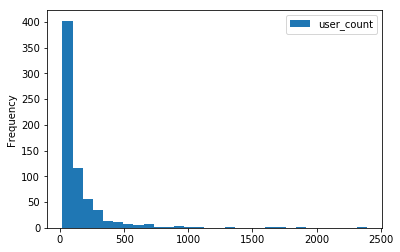

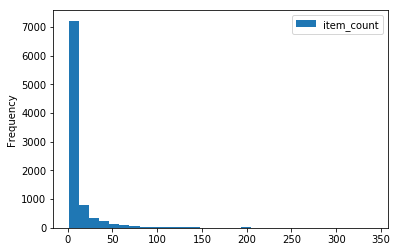

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
n = ratingDf.count()
ui_count  = ratingDf.agg(count('*').alias('ui'))
user_count = ratingDf.groupBy('user').agg(count('*').alias('user_count'))
item_count = ratingDf.groupBy('item').agg(count('*').alias('item_count'))
count_union = user_count.describe('user_count')\
          .join(item_count.describe('item_count'),on='summary',how='inner')
count_union.show()
print '稀疏度：%f%%' % (n/(671*9066*1.0)*100)
user_count.toPandas().plot.hist(bins=30)
item_count.toPandas().plot.hist(bins=30)


In [33]:
d = []
data = {'A':{'a':1,'b':1,'d':1},'B':{'b':1,'c':1,'e':1},'C':{'d':1,'d':1},'D':{'b':1,'d':1,'d':1},'E':{'a':1,'d':1}}
for k,v in data.items():
    d.append((k,v.items()))
df = spark.createDataFrame(
    sc.parallelize(d)\
    .flatMapValues(lambda x:x).map(lambda x:(x[0],x[1][0],x[1][1])),
    ['user','item','rating'])
item_pair_sim = itemSimilarity(df)  
item_pair_sim.cache()  
#     item_sim.saveAsTextFile('/tmp/item_sim')  
item_sim = item_pair_sim.filter(lambda f:f[1][1]>0.05)\
                    .groupByKey()\
                    .mapValues(list)\
                    .mapValues(lambda x:sorted(x)[:100]).collectAsMap()
item_sim_bd = sc.broadcast(item_sim)
recTopN = recommend(df,item_sim_bd,10)
pre = spark.createDataFrame(recTopN.flatMapValues(lambda x:x).map(lambda x:(x[0],x[1][0],x[1][1])),
                     ['user','item','rating'])
pre.show()

+----+----+------------------+
|user|item|            rating|
+----+----+------------------+
|   A|   c|0.5773502691896258|
|   A|   e|0.5773502691896258|
|   C|   a|0.7071067811865475|
|   C|   b|0.5773502691896258|
|   E|   b|0.9855985596534889|
|   B|   a|0.4082482904638631|
|   B|   d|0.5773502691896258|
|   D|   a|1.1153550716504106|
|   D|   c|0.5773502691896258|
|   D|   e|0.5773502691896258|
+----+----+------------------+

